#### cluster-specific setup, adjust this according to your own ###

In [ ]:
 #start a new Spark session, necessary for all Spark-related operations

from pyspark.sql import SparkSession

# we will use two pHMM models later on in the analysis
PFAM_HMM_PATHS = [
    "/PF00005.hmm",
    "/aa-activating.aroundLys.hmm"
]

# 'spark' and 'sc' are the canonical variable names for the SparkSession and SparkContext objects
spark = SparkSession.builder\
    .config("spark.files", ",".join([
        ",".join([PFAM_HMM_PATH + add for add in ["", ".h3f", ".h3i", ".h3m", ".h3p"]])
        for PFAM_HMM_PATH in PFAM_HMM_PATHS
    ]))\
    .getOrCreate()
sc = spark.sparkContext

In [ ]:
# point here to where the workshop's data folder is located
from os import path

DATA_FOLDER = "gs://zw_axolotl/jgi_workshop_2024/data"

In [ ]:
# point here to where we will store results from the activity (make sure it's empty and readable!)

RESULT_FOLDER = "./"

In [ ]:
# helper variable to set minimum repartition of the data (to use up all executors)

MIN_PARTITIONS = 100

#### variables setup and imports

In [ ]:
from pyspark.sql import functions as F # contain frequently-used functions
from pyspark.sql import types as T # for specifying schema datatypes, etc

# basic python libraries for data manipulation and visualization
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### The dataset
The full dataset comprises 13,223 "Species representative" genomes of the MGnify Marine V2.0 catalogue (https://www.ebi.ac.uk/metagenomics/genome-catalogues/marine-v2-0).

Each genome folder contain:
- Fasta files of the contig sequences: *.fna
- GFF3 files of gene-calling annotations: *.gff
- GFF3 files of BGC-calling annotations (using their in-house pipeline): *_sanntis.gff

The data folder "genomes_all" is organized by Phylum->Genus->Genome, for example:

- genomes_all
 - Actinomycetota
   - Streptomycetes
     - MYM000001
       - MYM000001.fna
       - MYM000001.gff
       - MYM000001_sanntis.gff
   - Microbacteria
   - ...
 - Pseudomonatota
   - ...
 - ...





In [ ]:
# Load the metadata (and persist it) for the entire dataset, as we will be using it later on

metadata_sdf = (spark.read
    .option("delimiter", "\t")
    .option("header", True)
    .option("inferSchema", True)
    .option("samplingRatio", 0.0001)
    .csv(path.join(DATA_FOLDER, "mgnify-marine-v2-0.tsv"))
).filter(F.col("Genome") == F.col("Species_rep")) # takes only the species representative genomes from the full 5X,XXX genomes

metadata_sdf.createOrReplaceTempView("metadata")
metadata_sdf.persist()
metadata_sdf.count()

In [ ]:
taxonomy_pq_path = path.join(RESULT_FOLDER, "df_taxonomy.pq") # from module_1

# we will load the taxonomy as SQL, after filtering it only for the 13,223 species rep genomes (via Join)
spark.read.parquet(taxonomy_pq_path).createOrReplaceTempView("taxonomy")
taxonomy_sdf = spark.sql("SELECT taxonomy.* FROM taxonomy JOIN metadata ON taxonomy.Genome=metadata.Genome")
taxonomy_sdf.createOrReplaceTempView("taxonomy")

taxonomy_sdf.persist()
taxonomy_sdf.count()

In [ ]:
# we will create a new table, to lookup the number of genomes + species included in a single genus
genus_stat_sdf = spark.sql((
    "SELECT Phylum, Genus, count(Genome) as num_genomes, count(distinct Species) as num_species"
    " FROM taxonomy"
    " GROUP BY Phylum, Genus"
))

genus_stat_sdf.createOrReplaceTempView("genus_stat")
genus_stat_sdf.persist().count()

# here is what the table looks like
genus_stat_sdf.orderBy("num_genomes", ascending=False).limit(10).toPandas()

#### For this activity, let's look up a total of <10 genomes from two different genera, all with unique species

In this case, we will arbitarily choose <i>Streptomyces</i> and <i>Kitasatospora</i>, two related genera that were known for their biosynthetic potentials.

In [ ]:
# First, we will look up the correct naming of our genera of choice, along with their genomes/species count
# we can use the wild card character '%' to search using the SQL query

spark.sql((
    "SELECT * FROM genus_stat"
    " WHERE Genus LIKE '%Strepto%' OR Genus LIKE '%Kita%'"
)).toPandas()

In [ ]:
# then let's encode and specify the genera to be selected, complete with its Phylum
included_genera = [
    ("p__Actinomycetota", "g__Streptomyces"),
    ("p__Actinomycetota", "g__Kitasatospora")
]

In [ ]:
# this is the function that will later on be used to generate
# the list of folder paths of each genus
# all unknown genera ('g__') is combined into a folder called 'unknown_genus'

def generate_folder_paths(list_of_genera, file_extension=None):
    return [path.join(DATA_FOLDER, "genomes_all", phylum.split("__")[1], genus.split("__")[1] if genus != "g__" else "unknown_genus") for phylum, genus in list_of_genera]

# for example, here is the folder we selected
generate_folder_paths(included_genera)

### Activity 2-1: Parsing FASTA files from scratch with Spark

First, let's make a FASTA parser function that takes: a **file path string** and a **nucleotide FASTA text (can be multi-sequences)** and output list of sequences and its IDs+headers, along with its original file path, as follow:

**Input:** ('example_fasta.fna',
'
&gt;seq_1 desc_1
<br/>ATGCATGCATGC<br/>ATGCATGCATGC

&gt;seq_2 desc_2
<br/>AAAAAAAAAAAA
<br/>TTTTTTTTTTTT
'

**Output:**

[<br/>
['example_fasta.fna', 'seq_1', 'desc_1', 'ATGCATGCATGCATGCATGCATGC'],<br/>
['example_fasta.fna', 'seq_2', 'desc_2', 'AAAAAAAAAAAATTTTTTTTTTTT']
<br/>]

This function will be called later in combination with Spark's parallel file parsing function 'wholeTextFiles()' to produce a Spark DataFrame.

In [ ]:
# this code is derived from chatGPT

import re

def parse_fasta(file_path, fasta_str):
    sequences = []
    fasta_entries = fasta_str.strip().split('>')

    for entry in fasta_entries:
        if entry:
            lines = entry.split('\n')
            header = lines[0]
            sequence = ''.join(lines[1:])

            match = re.match(r'(\S+)\s*(.*)', header)
            if match:
                seq_id = match.group(1)
                description = match.group(2)
                sequences.append([file_path, seq_id, description, sequence])

    return sequences

# test
file_path = "example.fasta"
fasta_str = """>seq1 Description of seq1
ATGCGTA
>seq2 Another description
GCTAGCTAGCTA
>seq3 Yet another description
TGCATGCA"""

%time parse_fasta(file_path, fasta_str)

#### Parsing using Spark's wholeTextFiles()

with Spark, we can use the wholeTextFiles() to scan and load text files into RDDs of string,
then pass it down to our parser function. This works well for smaller files that can fit each
into the worker's memory. See https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.wholeTextFiles.html

The function takes file paths as a single string, separated by <b>','</b>. You can use glob-style wildcard <b>'*'</b> to capture multiple files with the same pattern.

If you are parsing fewer, but big files, you would use https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.textFile.html instead.



In [ ]:
# let's generate the input fasta paths (using the function we wrote above, combining it with the included genera)
input_fasta_paths = [path.join(folder_path, "*/*.fna") for folder_path in generate_folder_paths(included_genera)]
input_fasta_paths

In [ ]:
# flatMap() is used to flatten the list of lists into single list (i.e., row in the dataframe)
from_spark_df = (sc.wholeTextFiles(",".join(input_fasta_paths)).flatMap(
    lambda tup: parse_fasta(tup[0], tup[1]) # wholeTextFiles output: RDD of (file_path, file_content_string)
).toDF(["file_path", "seq_id", "desc", "sequence"])
    .withColumn("length", F.length(F.col("sequence"))) # add a new column: length
)

from_spark_df.persist()
%time from_spark_df.count()

from_spark_df.limit(5).toPandas()

In [ ]:
# let's check the statistics
from_spark_df.select(
    F.countDistinct(F.col("file_path")).alias("num_files"),
    F.count(F.col("file_path")).alias("num_contigs"),
    F.min(F.col("length")).alias("min_length"),
    F.median(F.col("length")).cast("int").alias("med_length"),
    F.max(F.col("length")).alias("max_length")
).toPandas()

### Activity 2-2: Parsing FASTA & GFF files using Axolotl.IO

Rather than writing the parser function and dealing with the files ourselves, Axolotl already (and will) provide <b>parser classes</b> for many common file formats and data structures in Genomics (e.g., FASTA, GBK, GFF, VCF, etc.).

In [ ]:
from axolotl.io.fasta import FastaIO

# just like previously
input_fasta_paths = [path.join(folder_path, "*/*.fna") for folder_path in generate_folder_paths(included_genera)]

# this time, we use FastaIO class to load, which wraps around the original wholeTextFiles() function
contigs = FastaIO.loadSmallFiles(
    ",".join(input_fasta_paths),
    seq_type = "nucl",
    minPartitions = MIN_PARTITIONS
)
%time print(contigs.df.persist().count())
contigs.df.createOrReplaceTempView("contigs")

contigs.df.limit(3).toPandas()

In [ ]:
from axolotl.io.gff3 import gff3IO

# now we change the .fna into .gff
input_gff_paths = [path.join(folder_path, "*/*.gff") for folder_path in generate_folder_paths(included_genera)]

features = gff3IO.loadSmallFiles(
    ",".join(input_gff_paths),
    fasta_path_func = lambda x: x.rsplit(".", 1)[0].rsplit("_sanntis", 1)[0] + ".fna",
    minPartitions = MIN_PARTITIONS
)
%time print(features.df.persist().count())
features.df.createOrReplaceTempView("features")

features.df.limit(3).toPandas()

In [ ]:
# let's get some statistics for the parsed GFFs

spark.sql((
    "SELECT type, count(type) as total_rows from features"
    " GROUP BY type"
    " ORDER BY total_rows DESC"
)).toPandas().set_index("type")

### Exercise #1: Scaling Up Data without Changing the Code

Let's select these new genera below, totaling to around 38 genomes (~4x larger), for parsing. **Using Axolotl's fastaIO and gff3IO, can you parse those genomes into new DataFrames?**

Phylum - Genus

- Actinomycetota - Microbacterium (13 genomes)
- Bacteroidota - Aquimarina (10 genomes)
- Bacillota - Bacillus (9 genomes)
- Pseudomonadota - Kordiimonas (6 genomes)


**_Assign new variable and table names for the new DataFrames_ --> use contigs_2 for the FASTA files and features_2 for the GFF files, as they will be used in the follow-up blocks**. Hint: use the same code as previously (check boxes before this), but reassign the variables and the input array.

Put your code down here (remove the comment tags and fill in the blank '...' with the correct code):

In [ ]:
### SOLUTION E#1.block#1 ###

included_genera_2 = [
    ...code here...
]

In [ ]:
### SOLUTION E#1.block#2 ###

input_fasta_paths_2 = [...code here...]

contigs_2 = FastaIO.loadSmallFiles(
    ",".join(input_fasta_paths_2),
    seq_type = "nucl",
    minPartitions = MIN_PARTITIONS
)

%time print(contigs_2.df.persist().count())
contigs_2.df.createOrReplaceTempView("contigs_2")

contigs_2.df.limit(3).toPandas()

In [ ]:
### SOLUTION E#1.block#3 ###

input_gff_paths_2 = [...code here...]

features_2 = gff3IO.loadSmallFiles(
    ",".join(input_gff_paths_2),
    fasta_path_func = lambda x: x.rsplit(".", 1)[0].rsplit("_sanntis", 1)[0] + ".fna",
    minPartitions = MIN_PARTITIONS
)

%time print(features_2.df.persist().count())
features_2.df.createOrReplaceTempView("features_2")

features_2.df.limit(3).toPandas()

### Combining two DataFrames using .union()

Spark allows combining DataFrame (must be of the same structure) using DataFrame.union() function (see https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.union.html). Axolotl support the same operations in its DataFrames, **however, note that this will reset the indexes in the combined AxlDF**.

Below, we will **combine both the contig's and the feature's dataframes, then _persist them_**, so we can work on the combined version from this point forward.

In [ ]:
from axolotl.data.sequence import NuclSeqDF

contigs_combined = NuclSeqDF(contigs.df.union(contigs_2.df), override_idx=True)
contigs_combined.df.persist()
contigs_combined.df.createOrReplaceTempView("contigs_combined")
contigs_combined.df.count()

In [ ]:
spark.sql((
    "SELECT count(distinct file_path) as num_genomes, count(idx) as num_contigs FROM contigs_combined"
)).show()

In [ ]:
from axolotl.data.annotation import RawFeatDF

features_combined = RawFeatDF(features.df.union(features_2.df), override_idx=True)
features_combined.df.persist()
features_combined.df.createOrReplaceTempView("features_combined")
features_combined.df.count()

In [ ]:
spark.sql((
    "SELECT type, count(type) as total_rows from features_combined"
    " GROUP BY type"
    " ORDER BY total_rows DESC"
)).toPandas().set_index("type")

#### Let's generate some visualization for the combined data

<i>Map contig lengths per genus</i>

In [ ]:
# map out contig lengths per genus
ctg_length_summary = spark.sql((
    "SELECT printf('%s:%s ', Phylum, Genus) as genus, collect_list(log(length)) as ctg_lengths" # collect contig lengths per genus as a list
    " FROM contigs_combined JOIN taxonomy ON split(seq_id, '_')[0]=taxonomy.Genome" # join with taxonomy table using genome IDs
    " GROUP BY Phylum, Genus"
    " ORDER BY Phylum, Genus ASC"
)).toPandas()
ctg_length_summary

In [ ]:
plt.figure(figsize=(8, 4));
plt.title("Contig lengths (log10)");
plt.xticks(rotation=-30, ha="left");
plt.boxplot(ctg_length_summary["ctg_lengths"].values, labels=ctg_length_summary["genus"]);

In [ ]:
# map out BGC numbers per genome per genus
bgc_num_summary = spark.sql((
    "SELECT genus, collect_list(num_bgcs) as num_bgcs"
    " FROM (SELECT printf('%s:%s ', Phylum, Genus) as genus, count(type) as num_bgcs"
          " FROM features_combined JOIN taxonomy ON split(seq_id, '_')[0]=taxonomy.Genome"
          " WHERE type like 'CLUSTER'"
          " GROUP BY taxonomy.Genome, Phylum, Genus)"
    " GROUP BY genus"
    " ORDER BY genus ASC"
)).toPandas()

bgc_num_summary

In [ ]:
plt.figure(figsize=(8, 4));
#plt.title("Contig lengths (log10)");
plt.xticks(rotation=-30, ha="left");
plt.boxplot(bgc_num_summary["num_bgcs"].values, labels=bgc_num_summary["genus"]);

### Activity 2-3: Extracting BGC and CDS tables from Raw Features table

A common data preprocessing activity is transforming (through filtering, joining, function calling) one or more data tables into another. In this case, we take an example of transforming the RawFeatDF (features table) parsed directly from the GFF files into a separate cdsDF (which contain only CDS features data) and bgcDF (which contain only BGC features data).

<i>As a reference, the original RawFeatDF table looks like this:</i> (most of the important information is stored in the 'qualifiers' column)

In [ ]:
features_combined.df.limit(3).toPandas()

#### RawFeatDF -> cdsDF

<b>cdsDF</b>, as the name suggests, is an Axolotl dataframe class specifically made for storing Coding Sequences (CDS) information. In a typical genome annotation scenario (using GFF or GBK files), CDS information is stored as features, with type == 'CDS', and include information such as locus tag, gene id, etc.

In [ ]:
from axolotl.data.annotation import cdsDF

# to 'extract' cdsDF from a RawFeatDF table, we use the fromRawFeatDF() function
cds_combined = cdsDF.fromRawFeatDF(features_combined)
%time print(cds_combined.df.persist().count()) # persist this for further analysis

# this is what cdsDF table will looks like:
# the 'locus_tag', 'gene_name', etc. were derived from the original 'qualifiers' column of the RawFeatDF
cds_combined.df.limit(3).toPandas()

#### utilizing Axolotl's pre-made functions

Notice how in the table above, the 'aa_sequence' column seems to be empty. While some annotation pipeline store AA sequence in the feature qualifiers, some don't. In this case, we will need to re-translate based on the location of the CDS and the nucleotide sequences (i.e., codons) taken from the contigs.

In Axolotl, the cdsDF class support this function via the <b>cdsDF.translateAAs()</b> function. See below:

In [ ]:
# see how many CDS rows are untranslated
cds_combined.df.select(F.isnotnull(F.col("aa_sequence")).alias("have_translation")).groupBy("have_translation").count().toPandas()

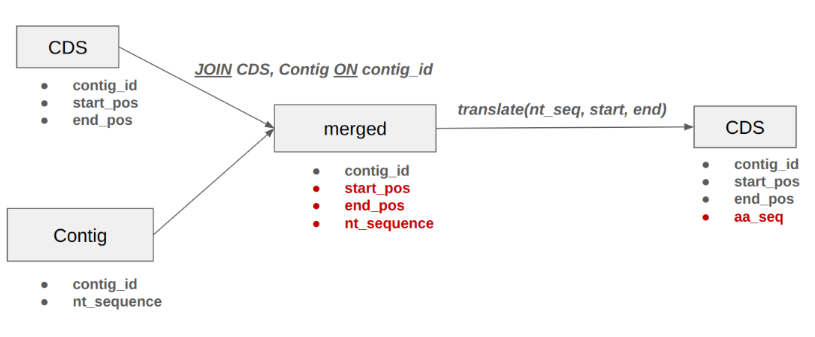

In [ ]:
# let's use Axolotl to translate the AAs.
# Since the GFF also doesn't provide transl_table value, we will use the most common table = 11
# this will take around 1.5 minutes

cds_combined_translated = cds_combined.translateAAs(contigs_combined, default_table=11) # assign into a new variable
%time cds_combined_translated.df.persist().count() # to kick start the process, we will persist and collect the new DF

cds_combined_translated.df.filter(F.isnotnull(F.col("aa_sequence"))).limit(3).toPandas() # let's see how the new table looks like

In [ ]:
# see how many CDS rows are now translated
cds_combined_translated.df.select(F.isnotnull(F.col("aa_sequence")).alias("have_translation")).groupBy("have_translation").count().toPandas()

In [ ]:
# let's plot the resulting AA lengths

plt.figure(figsize=(3, 6));
plt.title("CDS lengths");
plt.boxplot(cds_combined_translated.df.select(F.length(F.col("aa_sequence")).alias("length")).toPandas()["length"]);

## More fun stuff....

#### using Spark SQL, you can perform substring matching (or even regexp) on your CDSes

see https://spark.apache.org/docs/3.5.2/api/sql/#regexp for the regexp reference

#### let's use Spark SQL to find us some sigma factor genes, based on a motif taken from the sigma-70 pfam model:

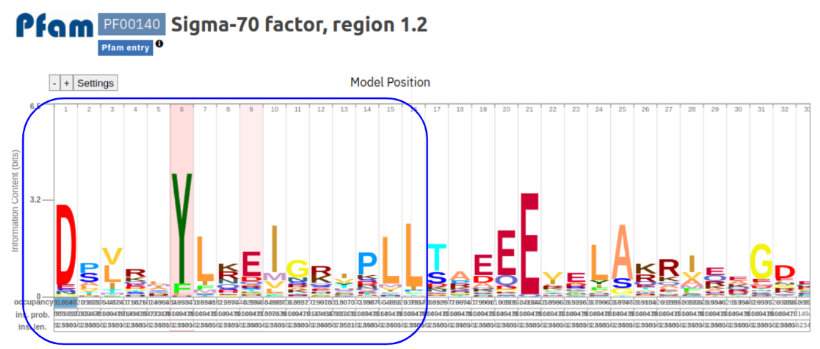

In [ ]:
cds_combined_translated.df.createOrReplaceTempView("cds_translated") # load it into SparkSQL

%time spark.sql((\
    "SELECT protein_name, Phylum, Genus FROM cds_translated"\
    " JOIN taxonomy ON split(seq_id, '_')[0]=Genome"\
    " WHERE aa_sequence LIKE '%D____YL__I____LL%'"\
)).groupBy("protein_name", "Phylum", "Genus").count().orderBy("protein_name", "Phylum").toPandas()

#### you can also perform parallel HMM scanning (using the pyHMMer library)...

While Axolotl doesn't yet have an extensive list of <b>pre-made functions and pipelines</b> to cover the breadth of analyses people may do in genomics, we implement some most common ones, partly in order to demonstrate how flexible the library is for incorporating external tools, libraries and softwares.

#### we will use Axolotl's built-in function to scan the ~195K CDSes for ABC transporters:

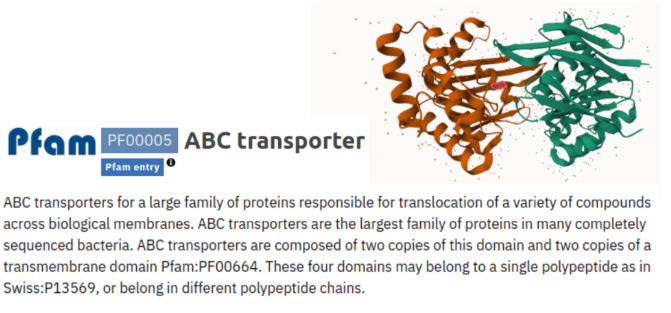

In [ ]:
# before that, let's see how much can we extract by doing a simple annotation query:
%time ab_trans_from_pandas = cds_combined_translated.df\
    .filter("protein_name LIKE '%ABC%'")\
    .groupBy("protein_name").count().orderBy("count", ascending=False).toPandas()

print("total:{:,}".format(ab_trans_from_pandas["count"].sum()))
ab_trans_from_pandas

In [ ]:
from axolotl.app.bgc_analysis.functions import scan_cdsDF

# the function takes a cdsDF object, and path to pHMM model
hmm_result = scan_cdsDF(cds_combined_translated, "PF00005.hmm")
%time hmm_result.persist().count() # persist right away, to analyse later

this is what the hit results table looks like:


In [ ]:
hmm_result.limit(3).toPandas()

In [ ]:
## how many CDSes?
hmm_result.select("cds_id").distinct().count()

In [ ]:
# what genes get picked up that doesn't have the 'ABC' in the name?

cds_combined_translated.df.createOrReplaceTempView("cds_source")
hmm_result.createOrReplaceTempView("abc_hits")

spark.sql((
    "SELECT protein_name, count(protein_name) as count"
    " FROM abc_hits JOIN cds_source ON cds_id=cds_source.idx"
    " WHERE protein_name NOT LIKE '%ABC%'"
    " GROUP BY protein_name"
    " ORDER BY count DESC"
)).toPandas()


#### the columns of the hits table, when combined with the original CDS sequence will allow regenerating the sequence->profile alignment:

In [ ]:
### custom functions that will take the data from hits table, then output the sequence to profile alignment

def get_aligned_to_model(seq, hmm_len, hmm_from, cds_from, cds_to, query_gaps, hmm_gaps):
    def calc_model_pos(cds_len, cds_from, cds_to, query_gaps, hmm_gaps):
        pos_in_model = []
        cursor_hmm = hmm_from
        cursor_cds = 1
        for i in range(cds_len):
            if cds_from <= (i+1) <= cds_to:
                while cursor_cds in query_gaps:
                    cursor_hmm += 1
                    cursor_cds += 1
                if cursor_hmm in hmm_gaps:
                    pos_in_model.append(-1)
                else:
                    pos_in_model.append(cursor_hmm)
                cursor_hmm += 1
                cursor_cds += 1
            else:
                pos_in_model.append(-1)
        return pos_in_model
    
    hits = calc_model_pos(len(seq), cds_from, cds_to, query_gaps, hmm_gaps)
    hits = { hits[i]: c for i, c in enumerate(seq) if hits[i] > -1 }
    return "".join([hits.get(i+1, "-")for i in range(hmm_len)])

# Register this into Spark SQL via the UDF interface
spark.udf.register("get_aligned_to_model", get_aligned_to_model);

In [ ]:
## let's test it out!

# first, we create a joined table of cds to hits, to get the original aa_sequence
merged_table = spark.sql((
    "SELECT cds_source.aa_sequence, abc_hits.*"
    " FROM abc_hits JOIN cds_source ON cds_id=cds_source.idx"
))
%time merged_table.persist().count()
merged_table.createOrReplaceTempView("merged_hits")

merged_table.limit(3).toPandas()

In [ ]:
# see the result:
spark.sql((
    "SELECT cds_id, cds_from, cds_to, get_aligned_to_model(aa_sequence, 100, hmm_from, cds_from, cds_to, cds_gaps, hmm_gaps) as alignment"
    " FROM merged_hits"
)).limit(10).toPandas()

#### ..there is also a module specifically meant for BGC analysis (as in the presentation)

In [ ]:
from axolotl.data.annotation import bgcDF

bgc_combined = bgcDF.fromRawFeatDF(
    features_combined,
    source_type="custom",
    kw_type="CLUSTER", # antiSMASH uses 'region' for its BGC designation, for example
    kw_classes="nearest_MiBIG_class" # this is specific to the GFFs from MGnify
)
%time print(bgc_combined.df.persist().count())

bgc_combined.df.limit(3).toPandas()

# Exercises

In this series of exercises, you will play with Axolotl's DataFrames to analyze the presence of <b>AMP-binding domain (https://www.ebi.ac.uk/interpro/entry/pfam/PF00501/) genes</b>.

This domain is found in a number of prokaryotic and eukaryotic enzymes, which appear to act via an ATP-dependent covalent binding of AMP to their substrate, share a region of sequence similarity. This region is a Ser/Thr/Gly-rich domain that is further characterised by a conserved Pro-Lys-Gly triplet. <i>This group of enzymes includes luciferase, long chain fatty acid Co-A ligase, long-chain fatty acid transport proteins that also function as acyl-CoA ligases, acetyl-CoA synthetase and various other closely-related synthetases.</i>

In secondary metabolite biosynthetic gene clusters (BGCs), this domain is a central part of the modular <b>Nonribosomal Peptide (NRPS) system</b>, to which the <b>specificity of the AMP-binding domain pocket may determine the amino-acid residue recruited to the growing NRP chain</b>.

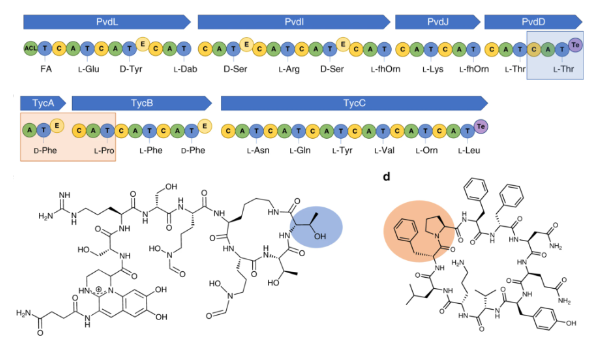


### Excercise #2: find AMP-binding domain genes by querying its motif

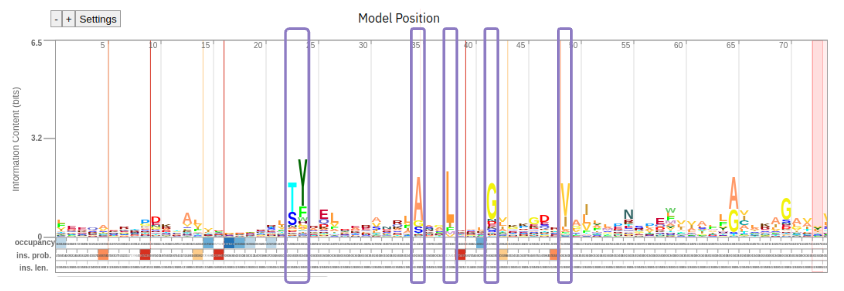

While the domain itself looked quite diverse, based on its Pfam signature, you can try to pick up some highly conserved motif to 'fish out' your CDSes. <b>TASK: complete the SQL query below to filter CDS based on the presence of the T[24] Y[25] A[35] L[38] G[42] V[49] motif</b> as highlighted.

In [ ]:
### SOLUTION E#2.block#1 ###

# here, we will use filtering to select CDS containing the motif
amp_cds_by_motif = spark.sql((
    "SELECT * FROM cds_source"
    " WHERE ...code here..."
))

# persist, and at the same time, count
# total count should be == 207
%time amp_cds_by_motif.persist().count()

In [ ]:
# now, let's see what kind of proteins get 'captured' by the motif (only the top-10)
# we will use GROUP BY to count the distinct protein names of the filtered data

amp_cds_by_motif.groupBy("protein_name").count().orderBy("count", ascending=False).limit(10).toPandas()

## Excercise #3: find AMP-binding domain genes by HMM scanning

In [ ]:
# first, we use the Axolotl function scan_cdsDF to perform HMM scanning
# the model name that will be used is aa-activating.aroundLys.hmm, taken
# from antiSMASH (the pHMM file contain two models: aa-activating-core.198-334
# and aroundLys, we will only use the former.

amp_hmm_result = scan_cdsDF(cds_combined_translated, "aa-activating.aroundLys.hmm", include_only=["aa-activating-core.198-334"])
%time amp_hmm_result.persist().count() # persist right away, to analyse later

# this results in 1,281 HMM hits (some genes will contain multiple domains)

In [ ]:
# let's quickly count how many CDSes got captured by this method?
# it will output 725 unique CDSes

amp_hmm_result.select("cds_id").distinct().count()

In [ ]:
### SOLUTION E#3.block#1 ###

# now, we will use JOIN to re-select the original CDS table
# based on the presence of AMP-binding HMM hits

# first, add the amp_hmm_result to the Spark SQL, name the table "amp_hits"
...code here...

# then we can perform the JOIN query as a filter (only cds with matching amp_hits will be kept.
# We select the original cds_source (now filtered), and use DISTINCT to remove duplicated rows
amp_cds_by_hmm = spark.sql((
    "SELECT DISTINCT cds_source.* FROM cds_source JOIN amp_hits ON cds_source.idx=amp_hits.cds_id"
))

# persist, and at the same time, count
# total count should be == 725
%time amp_cds_by_hmm.persist().count()

In [ ]:
### SOLUTION E#3.block#2 ###

# now, let's see what kind of proteins get 'captured' by the HMM (only the top-10)

amp_cds_by_hmm.groupBy(...code here...).count().orderBy(...code here...).limit(10).toPandas()

## Excercise #4: Extracting the "Stachelhaus" codes

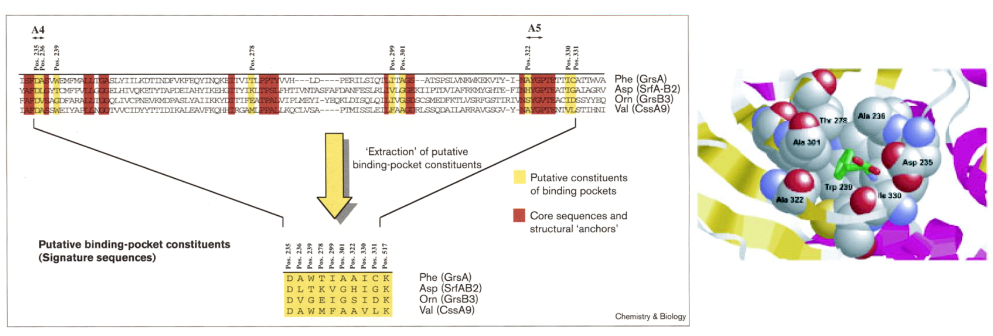

In [ ]:
### SOLUTION E#4.block#1 ###

# first, we create a joined table of cds to hits, to get the original aa_sequence
# this is taken from the previous example

merged_table_amp = spark.sql((
    "SELECT cds_source.aa_sequence, amp_hits.*"
    " FROM ...code here... JOIN ...code here... ON ...code here..."
))
%time merged_table_amp.persist().count()
merged_table_amp.createOrReplaceTempView("merged_hits_amp")

merged_table_amp.limit(3).toPandas()

In [ ]:
### SOLUTION E#4.block#2 ###

# now, generate the alignment table, similar to previous example
# for the AMP-binding, the model length is 166 (instead of 100)
amp_alignments = spark.sql((
    "SELECT cds_id, cds_from, cds_to,"
    " ...code here... as alignment"
    " FROM merged_hits_amp"
))
%time amp_alignments.persist().count()
amp_alignments.createOrReplaceTempView("amp_alignments")

amp_alignments.limit(10).toPandas()

In [ ]:
### SOLUTION E#4.block#3 ###

# now, let's write a UDF to extract the stachelhaus code 
# the 9-codes (excluding the last 'K')
# are located in position [46, 47, 50, 92, 124, 126, 153, 161, 162] in the model

def get_stachelhaus(alignment):
    POSITIONS = [46, 47, 50, 92, 124, 126, 153, 161, 162]
    return "".join([alignment[i] for i in POSITIONS])

# register the udf, name it "get_stachelhaus"
...code here...

# then apply the UDF
amp_stachelhaus = spark.sql((
    "SELECT cds_id, get_stachelhaus(alignment) as st_code FROM amp_alignments"
))
%time amp_stachelhaus.persist().count()
amp_stachelhaus.createOrReplaceTempView("amp_stachelhaus")

amp_stachelhaus.limit(10).toPandas()

In [ ]:
# filter only for full st_codes, then count the occurences

amp_stachelhaus.filter("NOT contains(st_code, '-')")\
    .groupBy("st_code").count()\
    .orderBy("count", ascending=False).limit(20).toPandas()

#### there is a lot more that you can do to explore the data
- can you map which AMP-binding domain hits are in the BGCs?
- what about the distribution of genus encoding specific type of stachelhaus codes?
- etc...

### <i>use your remaining time in the workshop to explore and ask questions!</i>